In [3]:
import plaidml.keras

In [4]:
plaidml.keras.install_backend()

In [5]:



from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


In [6]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [7]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'foto/cats_and_dogs_smalls'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [9]:

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.6268 - acc: 0.6615 - val_loss: 0.4532 - val_acc: 0.8310
Epoch 2/30
2000/2000 [==============================] - 1s 408us/step - loss: 0.4391 - acc: 0.8020 - val_loss: 0.3704 - val_acc: 0.8610
Epoch 3/30
2000/2000 [==============================] - 1s 407us/step - loss: 0.3661 - acc: 0.8340 - val_loss: 0.3273 - val_acc: 0.8800
Epoch 4/30
2000/2000 [==============================] - 1s 411us/step - loss: 0.3163 - acc: 0.8720 - val_loss: 0.3030 - val_acc: 0.8870
Epoch 5/30
2000/2000 [==============================] - 1s 404us/step - loss: 0.2936 - acc: 0.8745 - val_loss: 0.2913 - val_acc: 0.8840
Epoch 6/30
2000/2000 [==============================] - 1s 409us/step - loss: 0.2674 - acc: 0.8930 - val_loss: 0.2752 - val_acc: 0.8960
Epoch 7/30
2000/2000 [==============================] - 1s 426us/step - loss: 0.2418 - acc: 0.9080 - val_loss: 0.2684 - val_acc: 0.8930
Ep

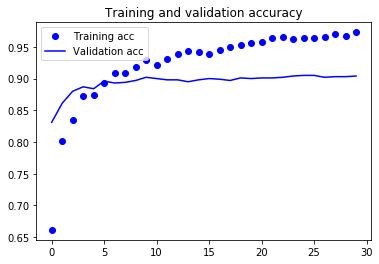

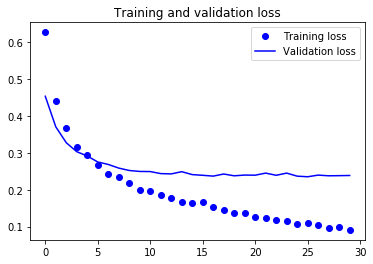

In [11]:

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show();

In [12]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [14]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [15]:
conv_base.trainable = False

In [16]:
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [17]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [18]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [19]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
 - 61s - loss: 0.5940 - acc: 0.6855 - val_loss: 0.4531 - val_acc: 0.8220
Epoch 2/30
 - 50s - loss: 0.4840 - acc: 0.7760 - val_loss: 0.3707 - val_acc: 0.8470
Epoch 3/30
 - 50s - loss: 0.4322 - acc: 0.8085 - val_loss: 0.3297 - val_acc: 0.8640
Epoch 4/30
 - 50s - loss: 0.4020 - acc: 0.8225 - val_loss: 0.3082 - val_acc: 0.8770
Epoch 5/30
 - 50s - loss: 0.3802 - acc: 0.8340 - val_loss: 0.3059 - val_acc: 0.8680
Epoch 6/30
 - 50s - loss: 0.3677 - acc: 0.8280 - val_loss: 0.2827 - val_acc: 0.8910
Epoch 7/30
 - 50s - loss: 0.3525 - acc: 0.8480 - val_loss: 0.2741 - val_acc: 0.8820
Epoch 8/30
 - 50s - loss: 0.3500 - acc: 0.8500 - val_loss: 0.2659 - val_acc: 0.8940
Epoch 9/30
 - 50s - loss: 0.3473 - acc: 0.8450 - val_loss: 0.2623 - val_acc: 0.8970
Epoch 10/30
 - 51s - loss: 0.3318 - acc: 0.8620 - val_loss: 0.2626 - val_acc: 0.8950
Epoch 11/30
 - 50s - loss: 0.3271 - acc: 0.8540 - val_loss: 0.2644 - val_acc: 0.8880
Epoch 12/30
 - 50s - loss: 0.3279 - acc: 0.8560 - val_loss: 0.2599 - val_a

In [20]:
model.save('cats_and_dogs_big_3.h5')

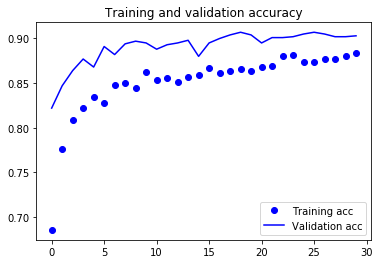

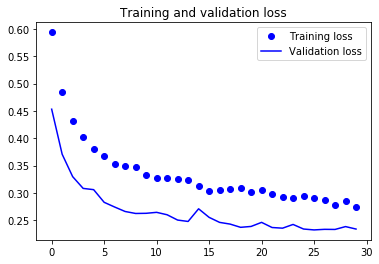

In [21]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [23]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [24]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 63s 627ms/step - loss: 0.2900 - acc: 0.8750 - val_loss: 0.2187 - val_acc: 0.9110
Epoch 2/100
100/100 [==============================] - 55s 555ms/step - loss: 0.2717 - acc: 0.8815 - val_loss: 0.2117 - val_acc: 0.9160
Epoch 3/100
100/100 [==============================] - 55s 553ms/step - loss: 0.2465 - acc: 0.8910 - val_loss: 0.2701 - val_acc: 0.8960
Epoch 4/100
100/100 [==============================] - 55s 552ms/step - loss: 0.2285 - acc: 0.9100 - val_loss: 0.2222 - val_acc: 0.9120
Epoch 5/100
100/100 [==============================] - 55s 554ms/step - loss: 0.2047 - acc: 0.9170 - val_loss: 0.1851 - val_acc: 0.9340
Epoch 6/100
100/100 [==============================] - 55s 553ms/step - loss: 0.1992 - acc: 0.9205 - val_loss: 0.1866 - val_acc: 0.9320
Epoch 7/100
100/100 [==============================] - 56s 557ms/step - loss: 0.1904 - acc: 0.9265 - val_loss: 0.1782 - val_acc: 0.9300
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 56s 558ms/step - loss: 0.0287 - acc: 0.9905 - val_loss: 0.2800 - val_acc: 0.9300
Epoch 62/100
100/100 [==============================] - 56s 556ms/step - loss: 0.0377 - acc: 0.9880 - val_loss: 0.2238 - val_acc: 0.9290
Epoch 63/100
100/100 [==============================] - 56s 557ms/step - loss: 0.0214 - acc: 0.9935 - val_loss: 0.2540 - val_acc: 0.9350
Epoch 64/100
100/100 [==============================] - 56s 557ms/step - loss: 0.0319 - acc: 0.9900 - val_loss: 0.2224 - val_acc: 0.9360
Epoch 65/100
100/100 [==============================] - 56s 556ms/step - loss: 0.0298 - acc: 0.9870 - val_loss: 0.2598 - val_acc: 0.9320
Epoch 66/100
100/100 [==============================] - 57s 573ms/step - loss: 0.0297 - acc: 0.9910 - val_loss: 0.2243 - val_acc: 0.9360
Epoch 67/100
100/100 [==============================] - 56s 556ms/step - loss: 0.0289 - acc: 0.9895 - val_loss: 0.2781 - val_acc: 0.9290
Epoch 68/100
100/100 [===================

In [25]:
model.save('cats_and_dogs_small_4.h5')

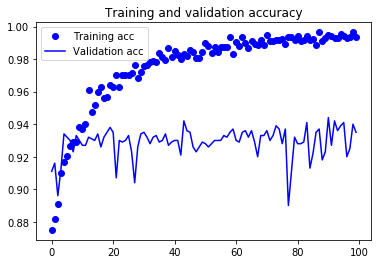

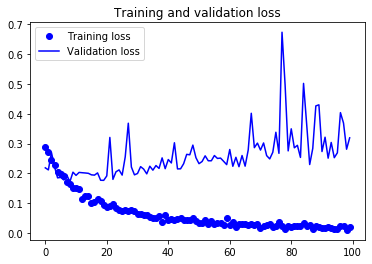

In [27]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show();

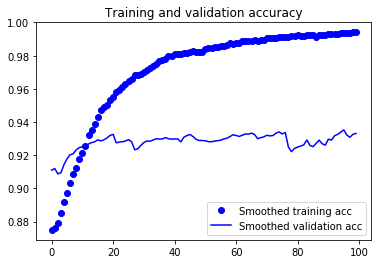

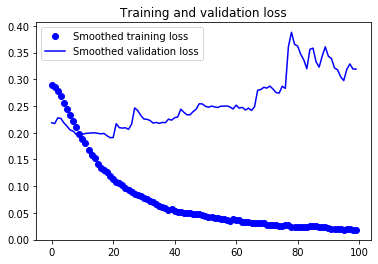

In [28]:

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9310000038146973


In [ ]:
##Пробуем использовать другую завгтовку

In [57]:
from keras.applications import VGG19

conv_base_NASN = VGG19 (weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [58]:
conv_base_NASN.summary();


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [59]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'foto/cats_and_dogs_smalls'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base_NASN.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features_1, train_labels_1 = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [61]:
conv_base_NASN.trainable = True

set_trainable = False
for layer in conv_base_NASN.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)